# Audio Features Extraction Analysis:

### Package imports:

In [3]:
# !pip install numpy
# !pip install pydub
# !pip install matplotlib
# pip install librosa => do from the shell, notebook won't work.
# !pip install umap-learn
# !pip install plotly
# ! pip install pandas
# pip install ipywidgets widgetsnbextension pandas-profiling => from command shell

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [5]:
# general purpose:
import os
import numpy as np
from matplotlib import pyplot as plt

# for audio operations:
from pydub import AudioSegment
import wave
import librosa
import soundfile as sf

# for feature visualization:
import umap
import plotly.express as px

# Plotly:
import plotly.express as px

# TSNE Approach:
from sklearn.manifold import TSNE

# UMAP Approach:
from umap import UMAP

### Utility functions:

In [7]:
# convert mp3 format to wav and save to specified folder (filename remains the same)
def save_mp3_as_wav(data_dir, mp3_filename, save_to_dir):
    mp3_file_abs_path = os.path.join(data_dir, mp3_filename)
    save_wav_file_as = os.path.join(save_to_dir, f"{mp3_filename.replace('.mp3', '.wav')}")
    sound = AudioSegment.from_mp3(mp3_file_abs_path)
    sound.export(save_wav_file_as, format="wav", bitrate="128k")

In [31]:
# save tmp LIE file for experiments:
save_mp3_as_wav(data_dir="../../../data/audio_data/",
                mp3_filename="trial_lie_005_008.mp3",
                save_to_dir=os.getcwd())

# save tmp TRUTH file for experiments:
save_mp3_as_wav(data_dir="../../../data/audio_data/",
                mp3_filename="trial_truth_058_001.mp3",
                save_to_dir=os.getcwd())

# Audio Features Approaches:

### Some general amplitutde over time visualization - *not very valuable for distinguishing deep details*

In [8]:
def show_audio_amplitutdeOverTime_features(wav_abs_path, title):
    # Open wav file and read frames as bytes
    sf_filewave = wave.open(wav_abs_path, 'r')  # 'trial_lie_048_006.wav', 'r')
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    print("soundwave_sf.shape:", soundwave_sf.shape)
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                          stop=len(soundwave_sf)/framerate_sf,
                          num=len(soundwave_sf))
    # Set up plot
    f, ax = plt.subplots(figsize=(15, 3))
    # Setup the title and axis titles
    plt.title('Amplitude over Time')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    # Add the audio data to the plot
    plt.plot(time_sf, soundwave_sf, label=title, alpha=0.5)
    plt.legend()
    plt.show()

soundwave_sf.shape: (342216,)


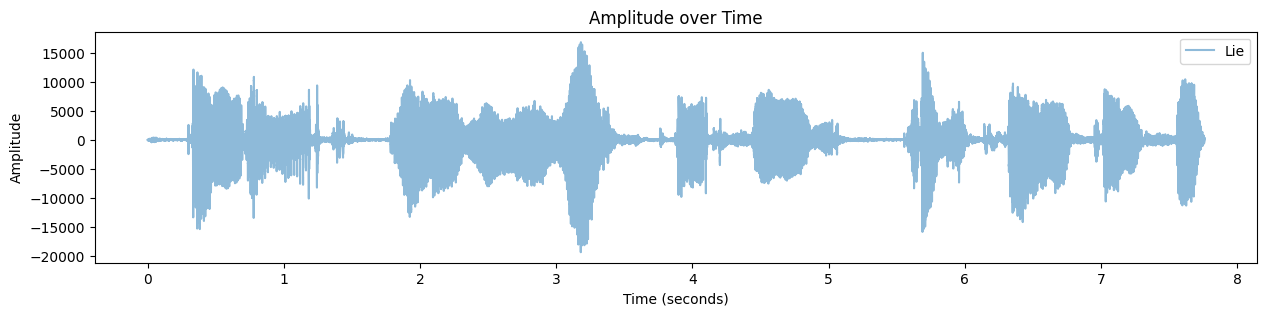

soundwave_sf.shape: (343980,)


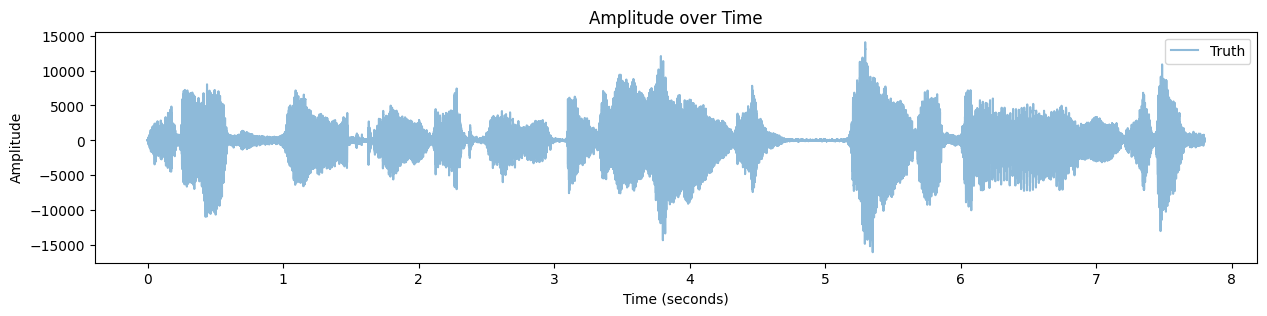

In [9]:
show_audio_amplitutdeOverTime_features(wav_abs_path="trial_lie_005_008.wav", title="Lie")
show_audio_amplitutdeOverTime_features(wav_abs_path="trial_truth_058_001.wav", title="Truth")

# Approaches for getting pitch (IMPORTANT FEATURES):
https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdaefe42

### 1. Root-mean-square (RMS)
- The root-mean-square here refers to the total magnitude of the signal, which in layman terms can be interpreted as the **loudness or energy parameter** of the audio file.

RMS.shape: (1, 168)
RMS.shape: (1, 168)


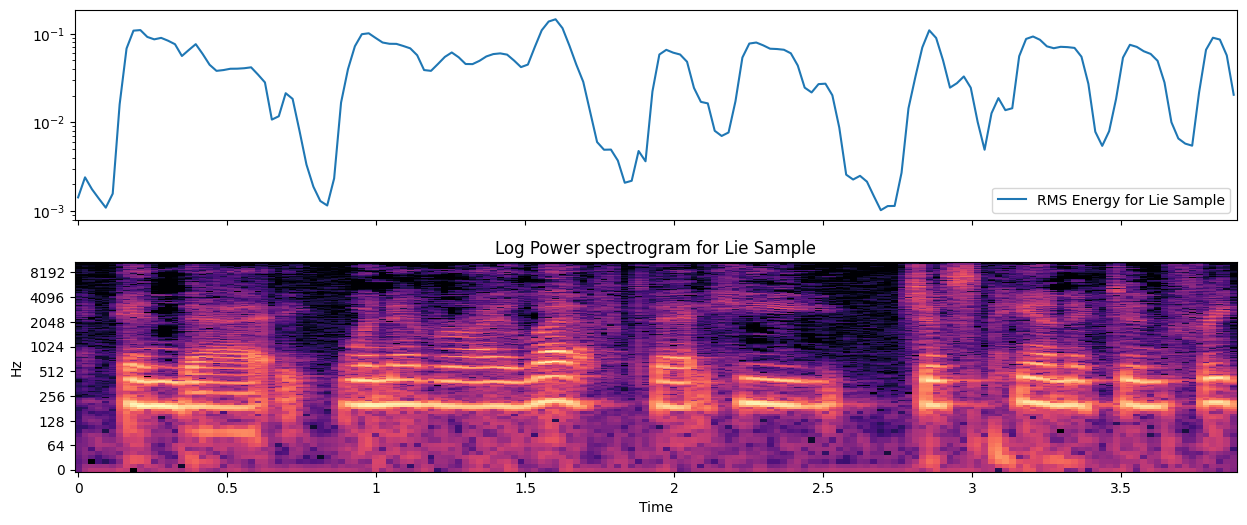

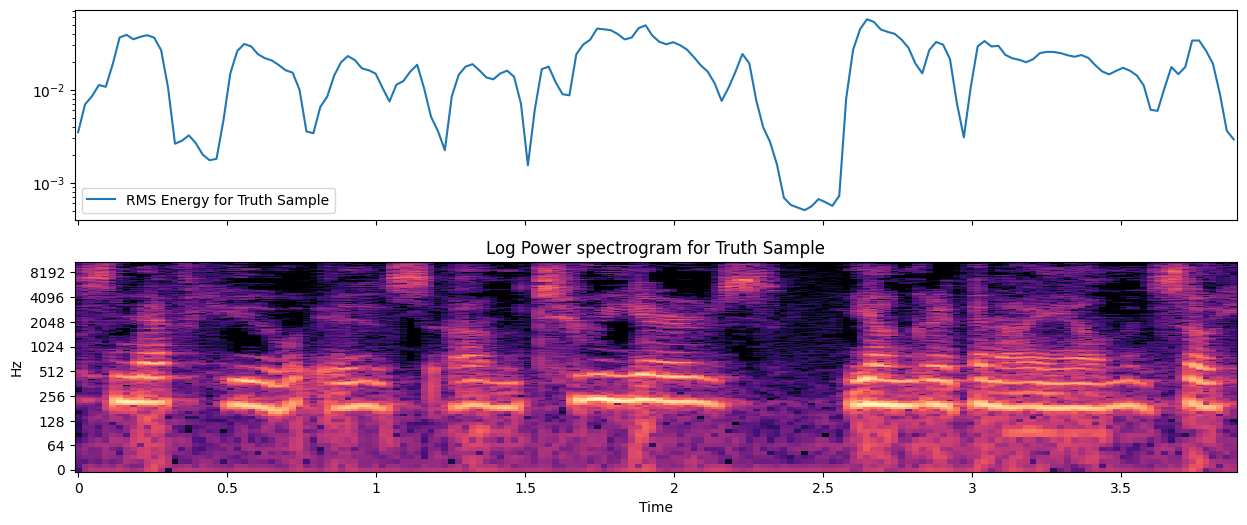

In [10]:
def get_audio_RMS_features(audio_file_abs_path, title, verbose=True):
    y, sr = librosa.load(audio_file_abs_path)
    # Get RMS value from each frame's magnitude value
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(S=S)
    # Plot the RMS energy
    if verbose:
        print("RMS.shape:", rms.shape)
        fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
        times = librosa.times_like(rms)
        ax[0].semilogy(times, rms[0], label=f'RMS Energy for {title}')
        ax[0].set(xticks=[])
        ax[0].legend()
        ax[0].label_outer()
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                 y_axis='log', x_axis='time', ax=ax[1])
        ax[1].set(title=f'Log Power spectrogram for {title}')
    
    return rms
    
tmp_RMS_lie_feature   = get_audio_RMS_features(audio_file_abs_path="trial_lie_005_008.wav", title="Lie Sample")
tmp_RMS_truth_feature = get_audio_RMS_features(audio_file_abs_path="trial_truth_058_001.wav", title="Truth Sample")

### 2. Mel-Frequency Cepstral Coefficients (MFCCs)
* Quoting Analytics Vidhya, humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies, even if the gap is the same (i.e `50 and 1,000 Hz` vs `10,000 and 10,500 Hz`). In Mel-scale, equal distances in pitch sounded equally distant to the listener.

* Mel-Frequency Cepstral Coefficients (MFCCs) is a representation of the short-term power spectrum of a sound, based on some transformation in a Mel-scale. It is commonly used in speech recognition as people’s voices are usually on a certain range of frequency and different from one to another. Getting and displaying MFCCs is quite straightforward in Librosa.

MFCC.shape: (20, 168)
MFCC.shape: (20, 168)


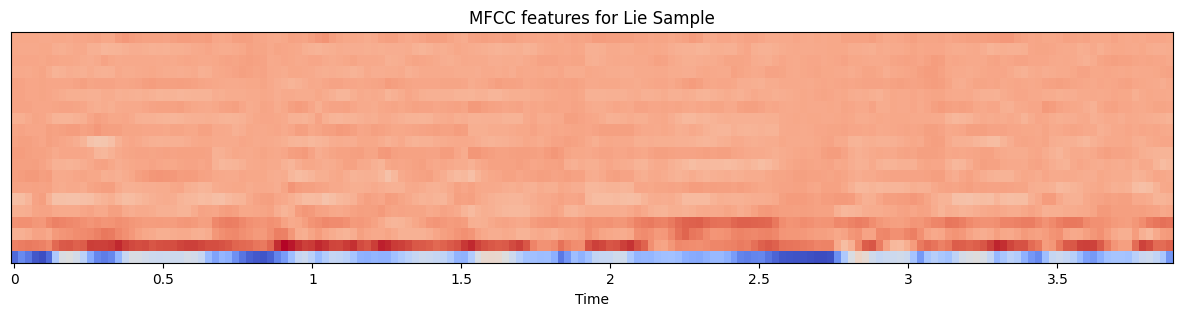

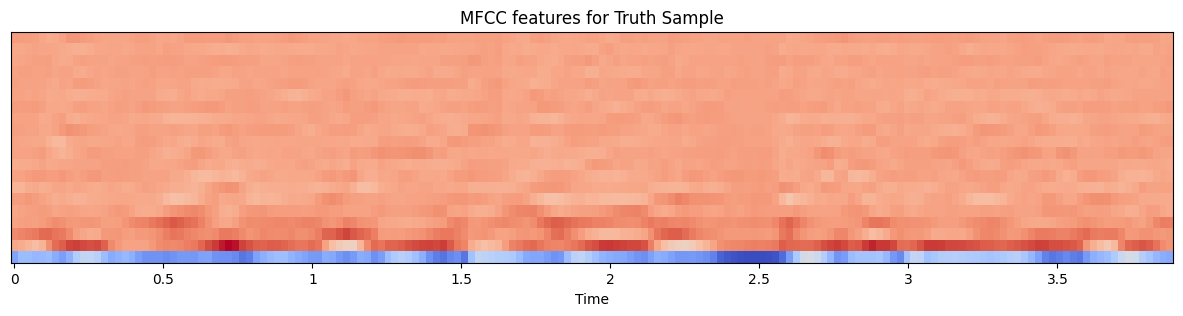

In [11]:
def get_audio_MFCC_features(audio_file_abs_path, title, verbose=True):
    audio_series, sr = librosa.load(audio_file_abs_path)
    mfccs = librosa.feature.mfcc(y=audio_series, sr=sr)
    if verbose:
        print("MFCC.shape:", mfccs.shape)
        # Displaying  the MFCCs:
        plt.figure(figsize=(15, 3))
        plt.title(f"MFCC features for {title}")
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    
    return mfccs
    
tmp_MFCC_lie_feature   = get_audio_MFCC_features(audio_file_abs_path="trial_lie_005_008.wav", title="Lie Sample")
tmp_MFCC_truth_feature = get_audio_MFCC_features(audio_file_abs_path="trial_truth_058_001.wav", title="Truth Sample")

### 3. Chroma feature
* In Western music, the term chroma feature or chromagram closely relates to the **twelve different pitch classes**. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.
https://en.wikipedia.org/wiki/Chroma_feature#:~:text=Chroma%2Dbased%20features%2C%20which%20are,to%20the%20equal%2Dtempered%20scale.

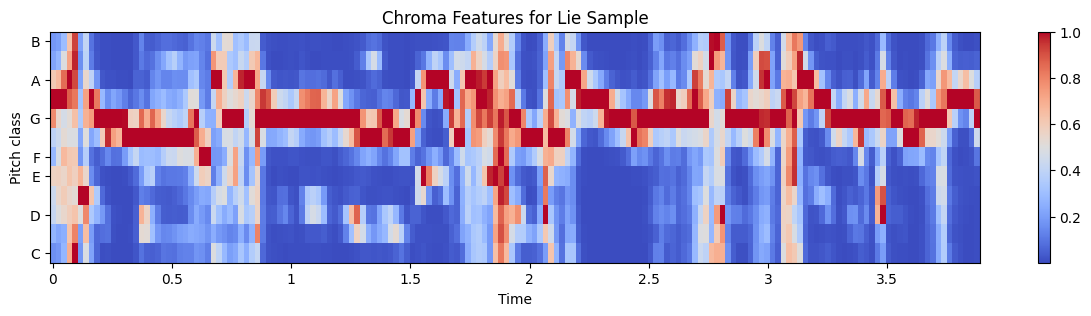

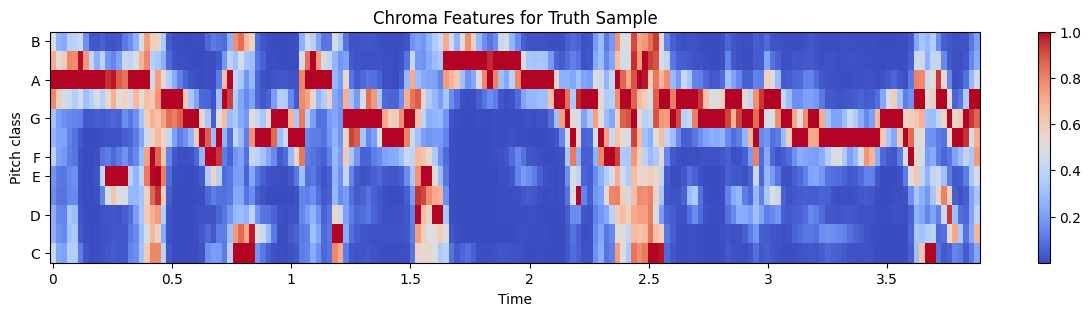

In [15]:
def get_audio_chroma_features(audio_file_abs_path, title, verbose=True):
    audio_series, sr = librosa.load(audio_file_abs_path)
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(y=audio_series, sr=sr, hop_length=hop_length)
    if verbose:
        print("chromagram.shape:", chromagram.shape)
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.set_title(f"Chroma Features for {title}")
        img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
        fig.colorbar(img, ax=ax)
    
    return chromagram
    
tmp_chroma_lie_feature   = get_audio_chroma_features(audio_file_abs_path="trial_lie_005_008.wav", title="Lie Sample")
tmp_chroma_truth_feature = get_audio_chroma_features(audio_file_abs_path="trial_truth_058_001.wav", title="Truth Sample")

# UMAP + Plotly - Visualizing audio Features to see how they differ between Lie and Truth classes:

In [16]:
print(tmp_chroma_lie_feature.shape, tmp_chroma_truth_feature.shape)

(12, 168) (12, 168)


In [33]:
(tmp_chroma_lie_feature+tmp_chroma_truth_feature).shape

(12, 168)

In [59]:
def tsne_dim_reduction(features, class_list_per_feature, class_title, verbose=True):
    print("Received features.shape:", features.shape)
    tsne = TSNE(n_components=3, random_state=0)
    projections = tsne.fit_transform(features, )

    if verbose:
        fig = px.scatter_3d(
            projections, x=0, y=1, z=2,
            color=class_list_per_feature, labels={'color': class_title}
        )
        fig.update_traces(marker_size=8)
        fig.show()
        
        
def umap_dim_reduction(features, class_list_per_feature, class_title, verbose=True):
    print("Received features.shape:", features.shape)
    umap_3d = UMAP(n_components=3, init='random', random_state=0)
    projections = umap_3d.fit_transform(features)  # proj_3d
    
    if verbose:
        fig = px.scatter_3d(
            projections, x=0, y=1, z=2,
            color=class_list_per_feature, labels={'color': class_title}
        )
        fig.update_traces(marker_size=8)
        fig.show()

# RMS can be affected by Microphone closeness.
# Whereas MFCC and Chroma can be independent from microphone distance or someone having higher voice.

tmp_RMS_lie_feature.shape: (1, 168)
tmp_RMS_truth_feature.shape: (1, 168)


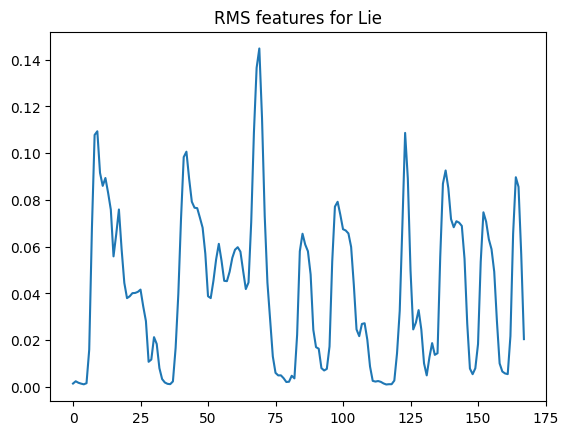

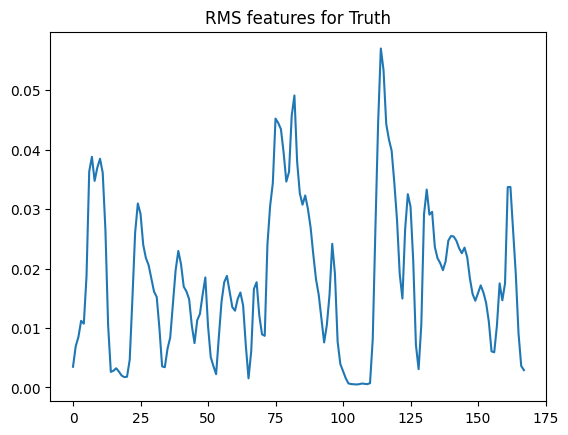

In [69]:
print("tmp_RMS_lie_feature.shape:", tmp_RMS_lie_feature.shape)
print("tmp_RMS_truth_feature.shape:", tmp_RMS_truth_feature.shape)

plt.figure()
plt.title("RMS features for Lie")
plt.plot(tmp_RMS_lie_feature.squeeze())
plt.show()
#-----------------
plt.figure()
plt.title("RMS features for Truth")
plt.plot(tmp_RMS_truth_feature.squeeze())
plt.show()

In [62]:
print("tmp_MFCC_lie_feature.shape:", tmp_MFCC_lie_feature.shape)
print("tmp_MFCC_truth_feature.shape:", tmp_MFCC_truth_feature.shape)

tsne_dim_reduction(features=np.swapaxes(np.array(np.concatenate((tmp_MFCC_lie_feature,tmp_MFCC_truth_feature), axis=1)), 0, 1),
                   class_list_per_feature=np.array([["Lie"]*168 + ["Truth"]*168]).squeeze(),
                   class_title="Deception Classes",
                   verbose=True)

tmp_MFCC_lie_feature.shape: (20, 168)
tmp_MFCC_truth_feature.shape: (20, 168)
Received features.shape: (336, 20)


In [63]:
# tmp_chroma_lie_feature
# tmp_chroma_truth_feature

tsne_dim_reduction(features=np.swapaxes(np.array(np.concatenate((tmp_chroma_lie_feature,tmp_chroma_truth_feature), axis=1)), 0, 1),
                   class_list_per_feature=np.array([["Lie"]*168 + ["Truth"]*168]).squeeze(),
                   class_title="Deception Classes",
                   verbose=True)

Received features.shape: (336, 12)


# Collect Audio Datasets for each feature time for further experiments:

In [ ]:
# Putting all above code together:

In [17]:
# RMS Features (for definition and description, please look above - Audio Analysis Notebook):
def get_audio_RMS_features(audio_file_abs_path, title, verbose=True):
    y, sr = librosa.load(audio_file_abs_path)
    # Get RMS value from each frame's magnitude value
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(S=S)
    # Plot the RMS energy
    if verbose:
        print("RMS.shape:", rms.shape)
        fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
        times = librosa.times_like(rms)
        ax[0].semilogy(times, rms[0], label=f'RMS Energy for {title}')
        ax[0].set(xticks=[])
        ax[0].legend()
        ax[0].label_outer()
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                 y_axis='log', x_axis='time', ax=ax[1])
        ax[1].set(title=f'Log Power spectrogram for {title}')
    
    return rms


# MFCC (Mel-Spectogram) Features (for definition and description, please look above - Audio Analysis Notebook):
def get_audio_MFCC_features(audio_file_abs_path, title, verbose=True):
    audio_series, sr = librosa.load(audio_file_abs_path)
    mfccs = librosa.feature.mfcc(y=audio_series, sr=sr)
    if verbose:
        print("MFCC.shape:", mfccs.shape)
        # Displaying  the MFCCs:
        plt.figure(figsize=(15, 3))
        plt.title(f"MFCC features for {title}")
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    
    return mfccs


# Chroma Features (for definition and description, please look above - Audio Analysis Notebook)
def get_audio_Chroma_features(audio_file_abs_path, title, verbose=True):
    audio_series, sr = librosa.load(audio_file_abs_path)
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(y=audio_series, sr=sr, hop_length=hop_length)
    if verbose:
        print("chromagram.shape:", chromagram.shape)
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.set_title(f"Chroma Features for {title}")
        img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
        fig.colorbar(img, ax=ax)
    
    return chromagram


# simple utility function to build
def mkdir_if_none(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        

# save features into numpy array
def save_npy_array(arr, filename, save_dir):
    filepath = os.path.join(save_dir, filename)
    np.save(file=filepath,
            arr=arr,
            allow_pickle=True)
        
        
# convert mp3 format to wav and save to specified folder (filename remains the same)
def save_mp3_as_wav(data_dir, mp3_filename, save_raw_dir, save_processed_dir, seconds_limit, chosen_sample_rate, bitrate):
    mp3_file_abs_path = os.path.join(data_dir, mp3_filename)
    save_raw_wav_file_as = os.path.join(save_raw_dir, f"{mp3_filename.replace('.mp3', '.wav')}")
    save_processed_wav_file_as = os.path.join(save_processed_dir, f"{mp3_filename.replace('.mp3', '.wav')}")
    # 1. first save raw file (in original form, just converted from mp3 to wav):
    sound = AudioSegment.from_mp3(mp3_file_abs_path)
    sound.export("tmp.wav", format="wav")  # , bitrate=bitrate)
    data, samlerate = sf.read("tmp.wav")
    sf.write(save_raw_wav_file_as, data, chosen_sample_rate, subtype='PCM_16')  # make sure to provide universal params across all audios
    os.remove("tmp.wav")
    # now, resample to uniform length (trim):
    sound = AudioSegment.from_wav(save_raw_wav_file_as)
    sound = sound[:seconds_limit*1000]
    sound.export(save_processed_wav_file_as, format="wav")  # , bitrate=bitrate)
    
        

# generate wav format data (from original) - will be same audios, but different format
def generate_wav_dataset(input_dir, save_raw_dir, save_processed_dir,
                         seconds_limit, chosen_sample_rate, bitrate):  # 22050
    # go over each mp3 file:
    for mp3_filename in os.listdir(input_dir):
        # and convert that mp3 to wav:
        save_mp3_as_wav(data_dir=input_dir,
                        mp3_filename=mp3_filename,
                        save_raw_dir=save_raw_dir,
                        save_processed_dir=save_processed_dir,
                        seconds_limit=seconds_limit,
                        chosen_sample_rate=chosen_sample_rate,
                        bitrate=bitrate)
        
        
# generate RMS audio features data (from wav dataset)
def generate_RMS_audio_features_dataset(input_dir, save_dir):
    # go over each wav file:
    for wav_filename in os.listdir(input_dir):
        # and convert that mp3 to wav:
        curr_RMS_features = get_audio_RMS_features(audio_file_abs_path=os.path.join(input_dir, wav_filename),
                                                   title="None",
                                                   verbose=False)
        # prepare filename => "trial_lie_005_008.wav" => "trial_lie_005_008_RMS.npy"
        current_RMS_save_as_filename = wav_filename.replace(".wav", "_RMS.npy")
        # finally, save it as numpy array to appropriate folder
        save_npy_array(arr=curr_RMS_features,
                       filename=current_RMS_save_as_filename,
                       save_dir=save_dir)
        
        
# generate MFCC audio features data (from wav dataset)
def generate_MFCC_audio_features_dataset(input_dir, save_dir):
    # go over each wav file:
    for wav_filename in os.listdir(input_dir):
        # and convert that mp3 to wav:
        curr_MFCC_features = get_audio_MFCC_features(audio_file_abs_path=os.path.join(input_dir, wav_filename),
                                                     title="None",
                                                     verbose=False)
        # prepare filename => "trial_lie_005_008.wav" => "trial_lie_005_008_MFCC.npy"
        current_MFCC_save_as_filename = wav_filename.replace(".wav", "_MFCC.npy")
        # finally, save it as numpy array to appropriate folder
        save_npy_array(arr=curr_MFCC_features,
                       filename=current_MFCC_save_as_filename,
                       save_dir=save_dir)

        
# generate Chroma audio features data (from wav dataset)
def generate_Chroma_audio_features_dataset(input_dir, save_dir):
    # go over each wav file:
    for wav_filename in os.listdir(input_dir):
        # and convert that mp3 to wav:
        curr_Chroma_features = get_audio_Chroma_features(audio_file_abs_path=os.path.join(input_dir, wav_filename),
                                                         title="None",
                                                         verbose=False)
        # prepare filename => "trial_lie_005_008.wav" => "trial_lie_005_008_Chroma.npy"
        current_Chroma_save_as_filename = wav_filename.replace(".wav", "_Chroma.npy")
        # finally, save it as numpy array to appropriate folder
        save_npy_array(arr=curr_Chroma_features,
                       filename=current_Chroma_save_as_filename,
                       save_dir=save_dir)

In [20]:
# Main function to collect audio features into folder datasets:
def collect_audio_features_RMS_MFCC_Chroma(input_dir, save_dir):
    
    # initialize paths to dataset folders:
    wav_raw_format_directory = os.path.join(save_dir, "wav_raw_format")                        # Place to store mp3 converted data
    wav_processed_format_directory = os.path.join(save_dir, "wav_processed_format")
    RMS_audio_features_directory = os.path.join(save_dir, "RMS_audio_features")        # dataset for RMS features
    MFCC_audio_features_directory = os.path.join(save_dir, "MFCC_audio_features")      # dataset for MFCC features
    Chroma_audio_features_directory = os.path.join(save_dir, "Chroma_audio_features")  # dataset for Chroma features
    
    # make datasets folders:
    mkdir_if_none(os.path.join(save_dir))                         # Main generated Audio Features dataset folder
    mkdir_if_none(os.path.join(wav_raw_format_directory))         # Place to store raw wav (mp3=>wav converted data), sr and bitRate set to universal ones
    mkdir_if_none(os.path.join(wav_processed_format_directory))   # store trimmed files
    mkdir_if_none(os.path.join(RMS_audio_features_directory))     # dataset for RMS features
    mkdir_if_none(os.path.join(MFCC_audio_features_directory))    # dataset for MFCC features
    mkdir_if_none(os.path.join(Chroma_audio_features_directory))  # dataset for Chroma features
    
    # Convert everything to mp3 first:
    generate_wav_dataset(input_dir=input_dir,
                         save_raw_dir=wav_raw_format_directory,
                         save_processed_dir=wav_processed_format_directory,
                         seconds_limit=3, chosen_sample_rate=44100, bitrate="128k")
    print("Finished with .WAV audio files generation.")
    
    # Now, generate RMS audio features dataset:
    generate_RMS_audio_features_dataset(input_dir=wav_processed_format_directory,
                                        save_dir=RMS_audio_features_directory)
    print("Finished with RMS audio feature files generation.")
    
    # Now, generate MFCC audio features dataset:
    generate_MFCC_audio_features_dataset(input_dir=wav_processed_format_directory,
                                         save_dir=MFCC_audio_features_directory)
    print("Finished with MFCC audio feature files generation.")
    
    # Now, generate Chroma audio features dataset:
    generate_Chroma_audio_features_dataset(input_dir=wav_processed_format_directory,
                                           save_dir=Chroma_audio_features_directory)
    print("Finished with Chroma audio feature files generation.")

In [21]:
collect_audio_features_RMS_MFCC_Chroma(input_dir="../../../data/audio_data/",
                                       save_dir="../../../data/audio_features/")

Finished with .WAV audio files generation.
Finished with RMS audio feature files generation.
Finished with MFCC audio feature files generation.
Finished with Chroma audio feature files generation.


# Check on size/shape of generated data:

In [9]:
def check_on_feature_shapes(input_dir):
    # get folder paths
    RMS_audio_features_folder = os.path.join(input_dir, "RMS_audio_features")
    MFCC_audio_features_folder = os.path.join(input_dir, "MFCC_audio_features")
    Chroma_audio_features_folder  = os.path.join(input_dir, "Chroma_audio_features")
    # shape check:
    RMS_features = np.load(os.path.join(RMS_audio_features_folder, "trial_lie_016_002_RMS.npy"))
    MFCC_features = np.load(os.path.join(MFCC_audio_features_folder, "trial_lie_016_002_MFCC.npy"))
    Chroma_features = np.load(os.path.join(Chroma_audio_features_folder, "trial_lie_016_002_Chroma.npy"))
    # print shapes:
    print("RMS_features.shape:", RMS_features.shape)
    print("MFCC_features.shape:", MFCC_features.shape)
    print("Chroma_features.shape:", Chroma_features.shape)
    print("----------------------------------------")
    print("Sample Data:")
    print("RMS_features:", RMS_features)
    print("MFCC_features:", MFCC_features)
    print("Chroma_features:", Chroma_features)
    
check_on_feature_shapes(input_dir="../../../data/audio_features/")

RMS_features.shape: (1, 336)
MFCC_features.shape: (20, 336)
Chroma_features.shape: (12, 336)
----------------------------------------
Sample Data:
RMS_features: [[0.00540103 0.01295142 0.01551422 0.01293388 0.01139303 0.00915761
  0.00726734 0.00862236 0.00860256 0.0099345  0.0159416  0.01896053
  0.02023035 0.02515664 0.03171067 0.03303437 0.03094406 0.03180014
  0.03179888 0.03237053 0.03040519 0.02845898 0.02814153 0.0256639
  0.02222113 0.01874388 0.01517397 0.01311273 0.01250274 0.01458829
  0.01666282 0.01690873 0.01593909 0.01362687 0.01352557 0.01574731
  0.01873757 0.01948356 0.01852528 0.01744073 0.01821179 0.01989379
  0.02008226 0.01718017 0.01419222 0.01234478 0.01123583 0.00867234
  0.00618222 0.00646133 0.00730784 0.00621102 0.0041755  0.00273134
  0.00189962 0.00189308 0.00227805 0.002493   0.00217956 0.00178774
  0.0017011  0.0017242  0.00204234 0.00185375 0.00148982 0.00147085
  0.00159453 0.00126453 0.00146422 0.00155765 0.00118955 0.00119188
  0.00125049 0.00127776 

# Feature Reduction Utils:

------------------------------------------------------------------------

------------------------------------------------------------------------

------------------------------------------------------------------------

# Chromagram (Old approach that was not tried):

In [70]:
# https://stackoverflow.com/questions/20730133/extracting-pitch-features-from-audio-file

# This is mostly Ubuntu supported, so in the interest of time, found Librosa approach 
# for chromagram extraction and omitted this choice.

In [26]:
# from bregman.suite import Chromagram
# audio_file = "../../data/audio_data/trial_lie_048_006.mp3"  # mono_file.wav"
# F = Chromagram(audio_file, nfft=16384, wfft=8192, nhop=2205)
# F.X # all chroma features
# F.X[:,0] # one feature